# MCC-RGB walkthrough

This notebook goes through the feature calculation and training steps of MCC-RGB to show the details behind the algorithm's update step. It also shows how the parameters for the radial basis function (RBF) kernel transformation and stochastic gradient descent (SGD) classifier can be selected with cross-validation.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from skimage.color import rgb2lab
from skimage.exposure import rescale_intensity

In [5]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [6]:
from pymccrgb.core import classify_ground_mcc
from pymccrgb.datasets import load_mammoth_lidar
from pymccrgb.plotting import plot_points_3d

## Color features

First, the default color features are calculated for each point. These are *a and b* color values from CIE-Lab color space and a green-red normalized difference index (NGRDVI). In RGB or CIR data, these features highlight green canopy points.

In [7]:
data = load_mammoth_lidar(npoints=1e5)

In [8]:
rgb = rescale_intensity(data[:, 3:6], out_range="uint8").astype(np.uint8)
red = rgb[:, 0]
green = rgb[:, 1]
blue = rgb[:, 2]
ngrdvi = (green - red) / (green + red)
lab = rgb2lab(np.array([rgb]))[0]
X = np.hstack([lab[:, 1:3].reshape(-1, 2), ngrdvi.reshape(-1, 1)])

In [9]:
xx = data[:, 0]
yy = data[:, 1]
zz = data[:, 2]

## 1. MCC ground classification

The algorithm starts with a ground classification based on relative height as in a single MCC iteration. A spline surface is interpolated through the data with grid resolution `scale`. High points are classified as non-ground if they lie at least `tol` untis above this surface. The result is a vector of point labels *y*.

MCC iterates over interpolation scales and height tolerances, removing non-ground points until a stopping condition is reached.

For more details, see [the MCC paper](https://doi.org/10.1109/TGRS.2006.890412) and [mcc-lidar codebase](https://sourceforge.net/p/mcclidar/wiki/Home/).

In [10]:
scale = 1  # m
tol = 0.3  # m
labels = classify_ground_mcc(data, scale, tol)
y = labels

In [11]:
keep = np.isfinite(X).all(axis=-1)
X = X[keep, :]
y = y[keep]
data = data[keep, :]

## 2. MCC-RGB update step

The goal of MCC-RGB is to refine the current MCC classification using the non-ground class. To do this, the color features from the point cloud are used to train a binary classifier trained using MCC class labels. 

Then, MCC ground points are re-classified using this classifier. If their predicted class is non-ground, they are re-labeled as non-ground points and removed before the next MCC iteration.

In [12]:
np.random.seed(10)
n_train = 1000
subset = np.random.choice(len(y), size=n_train)

In [13]:
X_train = X[subset, :]
y_train = y[subset]

In [14]:
print(f"Training points - Ground: {np.sum(y_train)} Nonground: {np.sum(y_train == 0)}")

Training points - Ground: 663 Nonground: 337


Text(0.5, 0.92, 'Training points')

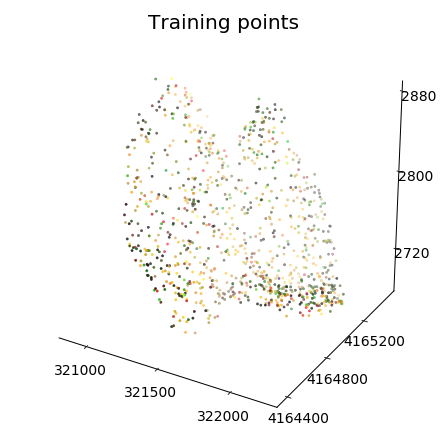

In [15]:
plot_points_3d(data[subset, :])
plt.gca().set_title("Training points")

Cross-validation can be used to determine reasonable values for the classifier parameters. 

In [16]:
pipe = Pipeline([('rbf', RBFSampler()), ('clf', SGDClassifier(max_iter=10, n_jobs=-1))])

In [17]:
gammas = [0.01, 0.1, 1, 10, 100, 1000]
n_components = [10, 100, 1000]
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'rbf__n_components': n_components,
              'rbf__gamma': gammas,
              'clf__alpha': Cs
             }

In [18]:
grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=param_grid)

In [19]:
grid.fit(X_train, y_train)

/home/rmsare/miniconda3/envs/pymcc/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rbf',
                                        RBFSampler(gamma=1.0, n_components=100,
                                                   random_state=None)),
                                       ('clf',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                                                      loss='hinge', max_

In [20]:
print(grid.best_params_)

{'clf__alpha': 0.001, 'rbf__gamma': 0.01, 'rbf__n_components': 1000}


In this example, high-dimensional RBF features with 1000 components and a gamma value of 0.01 will be derived from the color features. A stochastic gradient descent classifier is trained on these features using the MCC ground/non-ground labels.

In [21]:
pipe = Pipeline([('rbf', RBFSampler(n_components=1000, gamma=0.01)), ('clf', SGDClassifier(alpha=0.001, max_iter=10, n_jobs=-1))])

In [22]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('rbf',
                 RBFSampler(gamma=10, n_components=1000, random_state=None)),
                ('clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=10, n_iter_no_change=5, n_jobs=-1,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

Finally, MCC-RGB update steps use the predictions of the color-based classifier to update the original MCC ground points.

In [23]:
y_pred = pipe.predict(X)

Text(0.5, 0.92, 'Predicted ground points')

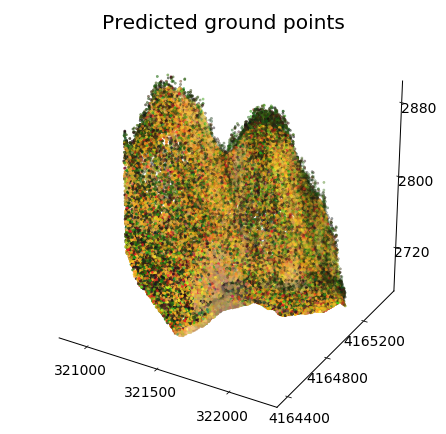

In [24]:
mask = y_pred == 1
plot_points_3d(data[mask, :])
plt.title('Predicted ground points')

Text(0.5, 0.92, 'Predicted nonground points')

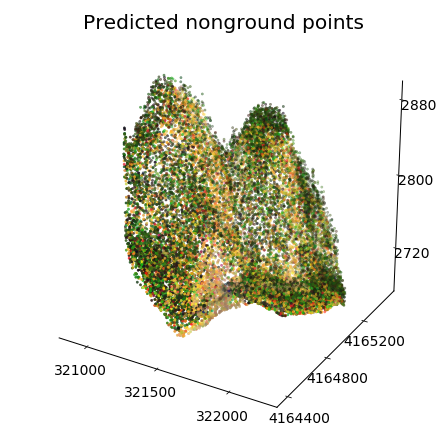

In [25]:
mask = y_pred == 0
plot_points_3d(data[mask, :])
plt.title('Predicted nonground points')

Text(0.5, 0.92, 'Updated MCC ground points')

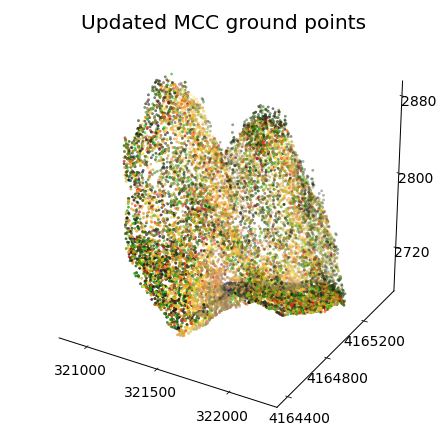

In [26]:
mask = (y_pred == 0) & (y == 1)
plot_points_3d(data[mask, :])
plt.title('Updated MCC ground points')